In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 16
mpl.rcParams.update({'errorbar.capsize': 4})

### An example movement trajectory

In [2]:
traj = np.load("../simulation_results/pts_traj_Q_C64E1_G_E4.5Em4_0.npy")
ninterval = traj.shape[0]-1
nc = traj.shape[1]

In [3]:
infile = open("../input_data/devmappath_Q_C64E1-G_E4.5Em4.pkl", "rb")
seq_path = pickle.load(infile)
common_genes = list( np.loadtxt("../input_data/common_genes.txt", dtype=str) )

In [4]:
seq_path_interp = np.empty([ninterval+1, nc, len(common_genes)])
x = np.arange(ninterval+1)/float(ninterval)
for ig in range(len(common_genes)):
    for ic in range(nc):
        tmp_gene = seq_path[ic][ig,:]
        seq_path_interp[:,ic, ig] = np.interp(x, np.arange(len(tmp_gene))/(len(tmp_gene)-1), tmp_gene)

0

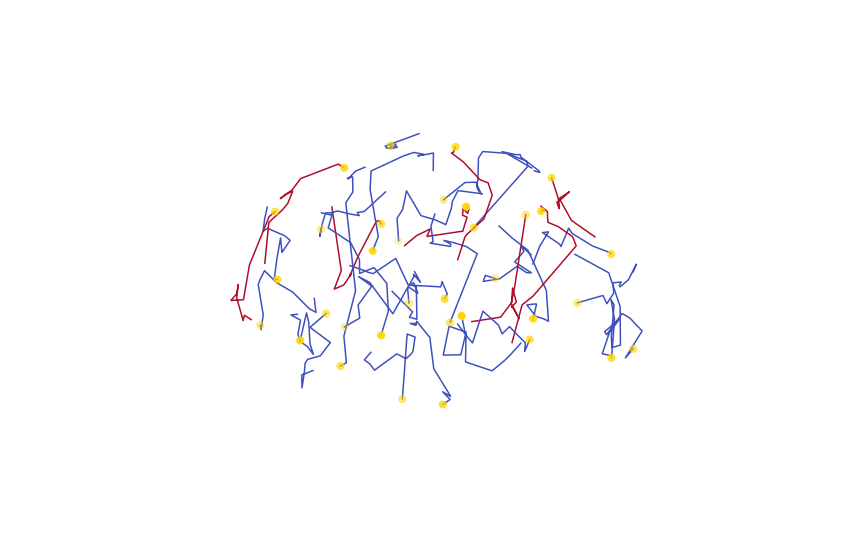

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(nc):
    if seq_path_interp[-1,i,common_genes.index("Nanog")] > 0.5:
        ax.plot(traj[:,i,0], traj[:,i,1], traj[:,i,2], c=(178/255,11/255,43/255))
    else:
        ax.plot(traj[:,i,0], traj[:,i,1], traj[:,i,2], c=(61/255,80/255,189/255))
ax.scatter(traj[-1,:,0], traj[-1,:,1], traj[-1,:,2], s=50, c='gold')
ax.view_init(10, 180)
plt.axis("off")
plt.savefig("./figures/traj.png", dpi=300)
os.system("convert -trim ./figures/traj.png ./figures/traj.png")

### Dynamics of Nanog and Gata6 expression

In [6]:
NG_start = seq_path_interp[0,:,np.array([common_genes.index("Nanog"), common_genes.index("Gata6")], int)].T
NG_end = seq_path_interp[-1,:,np.array([common_genes.index("Nanog"), common_genes.index("Gata6")], int)].T

ind_start_epi = np.where(NG_start[:,0] > NG_start[:,1])[0]
ind_start_pe = np.where(NG_start[:,0] < NG_start[:,1])[0]
ind_end_pe = np.where(NG_end[:,0] < NG_end[:,1])[0]
ind_end_epi = np.where(NG_end[:,0] > NG_end[:,1])[0]

ind_cells_epi_to_pe = np.intersect1d(ind_end_pe, ind_start_epi)
ind_cells_other = np.array([i for i in range(34) if not i in ind_cells_epi_to_pe], int)

/home/cang/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


0

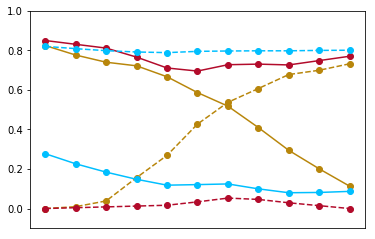

In [7]:
plt.plot(np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Nanog")], axis=1), '-o', color="darkgoldenrod")
plt.plot(np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Gata6")], axis=1), '--o', color="darkgoldenrod")
plt.plot(np.mean(seq_path_interp[:,ind_end_epi,common_genes.index("Nanog")], axis=1), '-o', color=(178/255,11/255,43/255))
plt.plot(np.mean(seq_path_interp[:,ind_end_epi,common_genes.index("Gata6")], axis=1), '--o', color=(178/255,11/255,43/255))
plt.plot(np.mean(seq_path_interp[:,ind_start_pe,common_genes.index("Nanog")], axis=1), '-o', color="deepskyblue")
plt.plot(np.mean(seq_path_interp[:,ind_start_pe,common_genes.index("Gata6")], axis=1), '--o', color="deepskyblue")
plt.ylim([-0.1,1])
plt.xticks([])
plt.savefig("./figures/NG_temporal.png", dpi = 300)
os.system("convert -trim ./figures/NG_temporal.png -transparent white ./figures/NG_temporal.png")

In [8]:
n_experiments = 50
Fgf_nb_turn = np.zeros([ninterval+1, n_experiments], float)
Fgfr_turn = np.zeros([ninterval+1, n_experiments], float)
Fgf_nb_other = np.zeros([ninterval+1, n_experiments], float)
Fgfr_other = np.zeros([ninterval+1, n_experiments], float)
Fgfr_Fgf_turn = np.zeros([ninterval+1, n_experiments], float)
Fgfr_Fgf_other = np.zeros([ninterval+1, n_experiments], float)
Bmp_nb_turn = np.zeros([ninterval+1, n_experiments], float)
Bmp_nb_other = np.zeros([ninterval+1, n_experiments], float)


for ii in range(0,n_experiments):
    i = ii
    traj = np.load("../simulation_results/pts_traj_Q_C64E1_G_E4.5Em4_"+str(i)+".npy")
    ninterval = traj.shape[0]-1
    nc = traj.shape[1]
    
    seq_path_interp_knn = np.empty_like(seq_path_interp)
    ngene = seq_path_interp.shape[-1]
    k = 5
    for it in range(ninterval+1):
        D = distance_matrix(traj[it,:,:], traj[it,:,:])
        for ic in range(nc):
            iknn = np.argsort(D[ic,:])[1:1+k]
            seq_path_interp_knn[it,ic,:] = np.mean(seq_path_interp[it,iknn,:], axis=0)
    
    Fgfr_turn[:,ii] = np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Fgfr2")], axis=1)
    Fgfr_other[:,ii] = np.mean(seq_path_interp[:,ind_cells_other,common_genes.index("Fgfr2")], axis=1)
    Fgf_nb_turn[:,ii] = np.mean(seq_path_interp_knn[:,ind_cells_epi_to_pe,common_genes.index("Fgf4")], axis=1)
    Fgf_nb_other[:,ii] = np.mean(seq_path_interp_knn[:,ind_cells_other,common_genes.index("Fgf4")], axis=1)
    Bmp_nb_turn[:,ii] = np.mean(seq_path_interp_knn[:,ind_cells_epi_to_pe,common_genes.index("Bmp4")], axis=1)
    Bmp_nb_other[:,ii] = np.mean(seq_path_interp_knn[:,ind_cells_other,common_genes.index("Bmp4")], axis=1)
    
    Fgfr_Fgf_turn[:,ii] = np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Fgfr2")] * seq_path_interp_knn[:,ind_cells_epi_to_pe,common_genes.index("Fgf4")], axis=1)
    Fgfr_Fgf_other[:,ii] = np.mean(seq_path_interp[:,ind_cells_other,common_genes.index("Fgfr2")] * seq_path_interp_knn[:,ind_cells_other,common_genes.index("Fgf4")], axis=1)

0

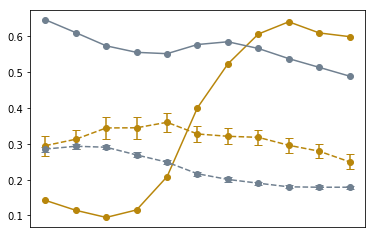

In [9]:
from scipy import stats

plt.plot(np.mean(Fgfr_turn, axis=1), '-o', color="darkgoldenrod")
plt.plot(np.mean(Fgfr_other, axis=1), '-o', color="slategrey")
ci_turn, ci_other = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Fgf_nb_turn[i,:])-1, loc=np.mean(Fgf_nb_turn[i,:]), scale=stats.sem(Fgf_nb_turn[i,:]))
    ci_turn[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Fgf_nb_other[i,:])-1, loc=np.mean(Fgf_nb_other[i,:]), scale=stats.sem(Fgf_nb_other[i,:]))
    ci_other[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Fgf_nb_turn, axis=1),yerr=ci_turn, color="darkgoldenrod", fmt='--o')
plt.errorbar(np.arange(11), np.mean(Fgf_nb_other, axis=1),yerr=ci_other, color="slategrey", fmt='--o')

plt.xticks([])
plt.savefig("./figures/Fgf_temporal.png", dpi = 300)
os.system("convert -trim ./figures/Fgf_temporal.png -transparent white ./figures/Fgf_temporal.png")

0

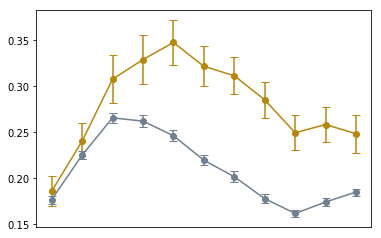

In [12]:
ci_turn, ci_other = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Bmp_nb_turn[i,:])-1, loc=np.mean(Bmp_nb_turn[i,:]), scale=stats.sem(Bmp_nb_turn[i,:]))
    ci_turn[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Bmp_nb_other[i,:])-1, loc=np.mean(Bmp_nb_other[i,:]), scale=stats.sem(Bmp_nb_other[i,:]))
    ci_other[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Bmp_nb_turn, axis=1),yerr=ci_turn, color="darkgoldenrod", fmt='-o')
plt.errorbar(np.arange(11), np.mean(Bmp_nb_other, axis=1),yerr=ci_other, color="slategrey", fmt='-o')
plt.xticks([])
plt.savefig("./figures/Bmp_temporal.png", dpi = 300)
os.system("convert -trim ./figures/Bmp_temporal.png -transparent white ./figures/Bmp_temporal.png")

0

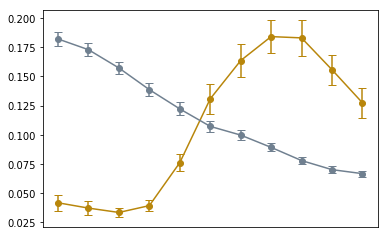

In [13]:
ci_turn, ci_other = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Fgfr_Fgf_turn[i,:])-1, loc=np.mean(Fgfr_Fgf_turn[i,:]), scale=stats.sem(Fgfr_Fgf_turn[i,:]))
    ci_turn[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Fgfr_Fgf_other[i,:])-1, loc=np.mean(Fgfr_Fgf_other[i,:]), scale=stats.sem(Fgfr_Fgf_other[i,:]))
    ci_other[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Fgfr_Fgf_turn, axis=1),yerr=ci_turn, color="darkgoldenrod", fmt='-o')
plt.errorbar(np.arange(11), np.mean(Fgfr_Fgf_other, axis=1),yerr=ci_other, color="slategrey", fmt='-o')
plt.xticks([])
plt.savefig("./figures/Fgfr_times_Fgf_temporal.png", dpi = 300)
os.system("convert -trim ./figures/Fgfr_times_Fgf_temporal.png -transparent white ./figures/Fgfr_times_Fgf_temporal.png")

In [14]:
import pandas as pd
df = pd.read_csv("../input_data/G_E4.5Em4.txt")
cellnames = list( df["CellName"] )

In [15]:
df = pd.read_csv("../data_preprocessing/scData/GSE100597_count_table_QC_filtered.txt", sep='\t', index_col=0)

In [16]:
genenames = list( df.index )

In [17]:
ind_start_epi = np.where(NG_start[:,0] > NG_start[:,1])[0]
ind_end_pe = np.where(NG_end[:,0] < NG_end[:,1])[0]
ind_end_epi = np.where(NG_end[:,0] > NG_end[:,1])[0]

ind_cells_epi_to_pe = np.intersect1d(ind_end_pe, ind_start_epi)
ind_cells_other = np.array([j for j in range(nc) if not j in ind_cells_epi_to_pe], int)
Epha4 = np.array( df[cellnames].T["Epha4_1_77367185"] ); Epha4 = np.log(Epha4+1.0)
Efnb2 = np.array( df[cellnames].T["Efnb2_8_8617434"] ); Efnb2 = np.log(Efnb2+1.0)
Ephb2 = np.array( df[cellnames].T["Ephb2_4_136647539"] ); Ephb2 = np.log(Ephb2+1.0)

In [18]:
n_experiments = 50
Epha4_nb = np.empty([ninterval+1, nc, n_experiments], float)
Efnb2_nb = np.empty([ninterval+1, nc, n_experiments], float)
Ephb2_nb = np.empty([ninterval+1, nc, n_experiments], float)

In [19]:
for i in range(n_experiments):
    traj = np.load("../simulation_results/pts_traj_Q_C64E1_G_E4.5Em4_"+str(i)+".npy")
    k = 5
    for it in range(ninterval+1):
        D = distance_matrix(traj[it,:,:], traj[it,:,:])
        for ic in range(nc):
            iknn = np.argsort(D[ic,:])[1:1+k]
            Epha4_nb[it,ic,i] = np.mean(Epha4[iknn])
            Efnb2_nb[it,ic,i] = np.mean(Efnb2[iknn])
            Ephb2_nb[it,ic,i] = np.mean(Ephb2[iknn])
Epha4_nb_epi = np.mean(Epha4_nb[:,ind_end_epi,:], axis=1)
Epha4_nb_pe = np.mean(Epha4_nb[:,ind_end_pe,:], axis=1)
Efnb2_nb_epi = np.mean(Efnb2_nb[:,ind_end_epi,:], axis=1)
Efnb2_nb_pe = np.mean(Efnb2_nb[:,ind_end_pe,:], axis=1)
Ephb2_nb_epi = np.mean(Ephb2_nb[:,ind_end_epi,:], axis=1)
Ephb2_nb_pe = np.mean(Ephb2_nb[:,ind_end_pe,:], axis=1)

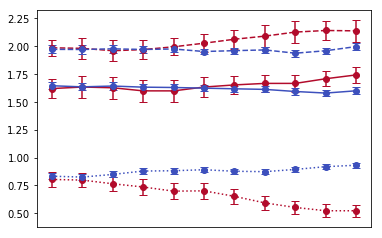

In [20]:
ci_epi, ci_pe = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Epha4_nb_epi[i,:])-1, loc=np.mean(Epha4_nb_epi[i,:]), scale=stats.sem(Epha4_nb_epi[i,:]))
    ci_epi[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Epha4_nb_pe[i,:])-1, loc=np.mean(Epha4_nb_pe[i,:]), scale=stats.sem(Epha4_nb_pe[i,:]))
    ci_pe[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Epha4_nb_epi, axis=1), yerr=ci_epi, fmt="-o", c=(178/255,11/255,43/255))
plt.errorbar(np.arange(11), np.mean(Epha4_nb_pe, axis=1), yerr=ci_pe, fmt="-o", c=(61/255,80/255,189/255))

ci_epi, ci_pe = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Efnb2_nb_epi[i,:])-1, loc=np.mean(Efnb2_nb_epi[i,:]), scale=stats.sem(Efnb2_nb_epi[i,:]))
    ci_epi[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Efnb2_nb_pe[i,:])-1, loc=np.mean(Efnb2_nb_pe[i,:]), scale=stats.sem(Efnb2_nb_pe[i,:]))
    ci_pe[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Efnb2_nb_epi, axis=1), yerr=ci_epi, fmt="--o", c=(178/255,11/255,43/255))
plt.errorbar(np.arange(11), np.mean(Efnb2_nb_pe, axis=1), yerr=ci_pe, fmt="--o", c=(61/255,80/255,189/255))

ci_epi, ci_pe = np.empty([ninterval+1]), np.empty([ninterval+1])
for i in range(ninterval+1):
    tmp_int = stats.t.interval(0.95, len(Ephb2_nb_epi[i,:])-1, loc=np.mean(Ephb2_nb_epi[i,:]), scale=stats.sem(Ephb2_nb_epi[i,:]))
    ci_epi[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
    tmp_int = stats.t.interval(0.95, len(Ephb2_nb_pe[i,:])-1, loc=np.mean(Ephb2_nb_pe[i,:]), scale=stats.sem(Ephb2_nb_pe[i,:]))
    ci_pe[i] = 0.5 * ( tmp_int[1] - tmp_int[0] )
plt.errorbar(np.arange(11), np.mean(Ephb2_nb_epi, axis=1), yerr=ci_epi, fmt="o", linestyle='dotted', c=(178/255,11/255,43/255))
plt.errorbar(np.arange(11), np.mean(Ephb2_nb_pe, axis=1), yerr=ci_pe, fmt="o", linestyle='dotted', c=(61/255,80/255,189/255))
plt.xticks([])
plt.savefig("./figures/Epha4_Ephb2_Efnb2_temporal.png", dpi=300)
os.system("convert -trim ./figures/Epha4_Ephb2_Efnb2_temporal.png -transparent white ./figures/Epha4_Ephb2_Efnb2_temporal.png")
plt.show()

In [21]:
expression = np.empty([nc*3], float)
expression[:nc] = Epha4[:]; expression[nc:2*nc]=Ephb2[:]; expression[2*nc:] = Efnb2[:]
gene = [1 for i in range(nc)] + [2 for i in range(nc)] + [3 for i in range(nc)]
celltype = []
for i in range(nc):
    if i in ind_end_epi:
        celltype.append(1)
    else:
        celltype.append(-1)
celltype = celltype + celltype + celltype

df = pd.DataFrame(data=[expression, gene, celltype], index=['Expression','Gene','CellType']).T

/home/cang/.local/lib/python3.6/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


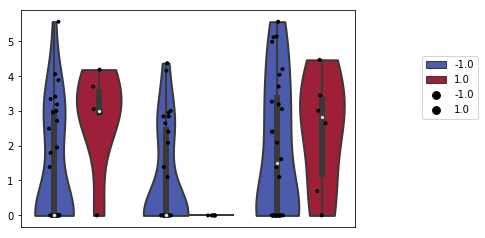

In [22]:
import seaborn as sns
ax = sns.stripplot(x="Gene", y="Expression", hue="CellType", split=True, data=df, palette={1:"k", -1:"k"}, size=4)
sns.violinplot(ax=ax, x="Gene", y="Expression", hue="CellType", data=df, palette={1:(178/255,11/255,43/255), -1:(61/255,80/255,189/255)}, fontsize=20, cut=0, scale='area', linewidth=2, bw='scott', inner="box")

ax.legend(loc=(1.2,0.5))
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/Epha4_Ephb2_Efnb2_violin.png", dpi=300)
plt.show()